In [1]:
# voxel morph imports
import tensorflow as tf
import voxelmorph as vxm
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

import numpy as np
import h5py

import utilitary as util

#plotting
import matplotlib.pyplot as plt
import neurite as ne

In [2]:
hf = h5py.File("epfl3.h5", "r")

In [3]:
np.random.seed(336699)

nb_entries = len(hf.keys())
list_keys = list(hf.keys())
keys_random = np.random.permutation(list_keys)

keys_train = keys_random[:int(nb_entries*0.8)]
keys_test  = keys_random[int(nb_entries*0.8):]

#x,y,z = hf.get("0")["frame"][0].shape

In [4]:
# keys in test with labels mask
mask_tests = []
for i in keys_test:
    if len(hf.get(i)) > 1:
        mask_tests.append(i)
        
# keys in test with labels mask
mask_trains = []
for i in keys_train:
    if len(hf.get(i)) > 1:
        mask_trains.append(i)

## Semi-supervised

In [5]:
vol_shape = (112, 112, 32)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

label_vals = np.array([1,2,3,4,5,6,7])

vxm_model = vxm.networks.VxmDenseSemiSupervisedSeg(
                                        inshape=vol_shape,
                                        nb_labels=len(label_vals),
                                        nb_unet_features=nb_features,
                                        int_steps=0);
key_fixed = 904


fixed_vol = np.array(hf.get(str(key_fixed))["frame"][0][:,:,:])/255
fixed_seg = np.array(hf.get(str(key_fixed))["mask"])

## MSE
#vxm_model.load_weights("semisup5e-5_all_labels5e-05.keras")
#vxm_model.load_weights("semisup5e-2_all_labels5e-02.keras")
#vxm_model.load_weights("semisup_01_all_labels0.1.keras")

##NCC
vxm_model.load_weights("semisup_ncc_all_labels_32epoch0.9.keras")

Instructions for updating:
Use fn_output_signature instead


In [6]:
### PREDICTION ON UNSEEN DATA

#val -> test npz
vols_names = ['vol'+str(i)+'.npz' for i in keys_test]

predict_generator = vxm.generators.semisupervised(
                        vol_names=vols_names,
                        labels=label_vals)

val_input = [next(predict_generator) for i in range(len(mask_tests))]

# predict the transformation
val_pred = []
for i in range(len(mask_tests)):
    val_pred.append(vxm_model.predict(val_input[i]))
    
#warp_generator = util.vxm_data_generator(slices_train_3d_mask,
                                         # vol_fixed=fixed_vol,
                                          #batch_size=1)

In [ ]:
### PREDICTION ON TRAINING DATA

#vol -> training npz
vols_names_tr = ['vol'+str(i)+'.npz' for i in keys_train]

predict_generator = vxm.generators.semisupervised(
                        vol_names=vols_names_tr,
                        labels=label_vals)


val_input = [next(predict_generator) for i in range(len(mask_trains))]

# predict the transformation
val_pred = []
for i in range(len(mask_trains)):
    val_pred.append(vxm_model.predict(val_input[i]))

# predict the transformation

In [7]:
warp_model = vxm.networks.Transform(vol_shape, interp_method='nearest')

In [8]:
#checking that it's the right prediction vector
assert (len(mask_tests) == len(val_pred))

#load the test set + normalization
#slices_test_3d_frame = np.empty((len(mask_tests),112,112,32))
slices_test_3d_mask = np.empty((len(mask_tests),112,112,32))
for i, key in enumerate(mask_tests):
    #slices_test_3d_frame[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255
    slices_test_3d_mask[i] = np.array(hf.get(key)["mask"])
    #slices_test_3d_mask[i][np.where(slices_train_3d_mask[i] != 4)] = 0

# predict the labels transformation (unseen data)
warped_seg = [warp_model.predict([slices_test_3d_mask[i][np.newaxis,...,np.newaxis], val_pred[i][1]]) for i in range(len(mask_tests))]

dice = [vxm.py.utils.dice(slices_test_3d_mask[i], fixed_seg, label_vals) for i in range(len(mask_tests))]
#mean_dice, std_dice = avg_dice_score(slices_test_3d_mask, fixed_seg)
print("before warping (rough alignment)")
#print(dice.mean())
#print(dice.std())
warped_seg = np.array(warped_seg)

dice_warp = [vxm.py.utils.dice(warped_seg.squeeze()[i], fixed_seg, label_vals) for i in range(len(mask_tests))]
#mean_dice, std_dice = avg_dice_score(warped_seg.squeeze(), fixed_seg)
print("after warping")
#print(dice_warp.mean())
#print(dice_warp.std())

before warping (rough alignment)
after warping


In [9]:
dice = np.array(dice)
dice_warp = np.array(dice_warp)Je sais

In [10]:
i =3
print(dice[:,i].mean())
print(dice[:,i].std())
print('***')
print(dice_warp[:,i].mean())
print(dice_warp[:,i].std())

0.5274078673912717
0.22635830307831672
***
0.5136759294846884
0.196082921471492


In [11]:
print(dice.mean())
print(dice.std())

0.3177257054361897
0.29381780684812686


In [12]:
print(dice_warp.mean())
print(dice_warp.std())

0.2960589320898904
0.28417368482555944


In [11]:
#checking that it's the right prediction vector
assert (len(mask_trains) == len(val_pred))
    
#load the training set + normalization
#slices_train_3d_frame = np.empty((len(mask_trains),112,112,32))
slices_train_3d_mask = np.empty((len(mask_trains),112,112,32))
for i, key in enumerate(mask_trains):
    #slices_train_3d_frame[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255
    slices_train_3d_mask[i] = np.array(hf.get(key)["mask"])
    #slices_train_3d_mask[i][np.where(slices_train_3d_mask[i] != 4)] = 0

# predict the labels transformation (training data)
warped_seg = [warp_model.predict([slices_train_3d_mask[i][np.newaxis,...,np.newaxis], val_pred[i][1]]) for i in range(len(mask_trains))]
means_dice_no_warp = vxm.py.utils.dice(slices_train_3d_mask, fixed_seg, label_vals)
#mean_dice, std_dice = avg_dice_score(slices_train_3d_mask, fixed_seg)
print("before warping (rough alignment)")
print(means_dice_no_warp.mean())
print(means_dice_no_warp.std())

warped_seg = np.array(warped_seg)
means_dice_warp = vxm.py.utils.dice(warped_seg.squeeze(), fixed_seg, label_vals)
#mean_dice, std_dice = avg_dice_score(warped_seg.squeeze(), fixed_seg)
print("after warping")
print(means_dice_warp.mean())
print(means_dice_warp.std())

before warping (rough alignment)
0.6684424624287555
0.29168842949727697
after warping
0.690531489514495
0.2540972284700225


In [23]:
mask_tests[6]

'500'

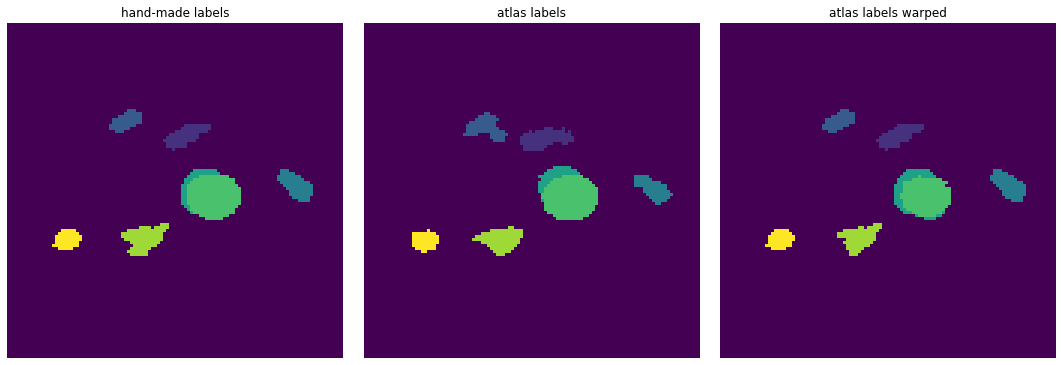

(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'hand-made labels'}>,
        <AxesSubplot:title={'center':'atlas labels'}>,
        <AxesSubplot:title={'center':'atlas labels warped'}>], dtype=object))

In [9]:
idx=6
titles = ['hand-made labels', 'atlas labels', 'atlas labels warped']
ne.plot.slices([np.max(slices_test_3d_mask[idx],axis=2),
                np.max(fixed_seg, axis=2),
                np.max(warped_seg[idx].squeeze(),axis=2)],
              titles=titles)

## Normalized cross correlation

In [13]:
#ground truth
gt = []
#vxm perf
vxm = []
for i in range(len(slices_test_3d_mask)):
    #rough prealign
    gt.append(np.corrcoef(slices_test_3d_mask[i].ravel(),
                    fixed_seg.ravel())[0,1])
    
    
    #after morphing
    vxm.append(np.corrcoef(slices_test_3d_mask[i].ravel(),
                    warped_seg[i].squeeze().ravel())[0,1])

In [14]:
np.array(gt).mean()

0.4549534176719892

In [15]:
np.array(vxm).mean()

0.6494964188486524

In [16]:
np.array(gt).std()

0.2591554221503907

In [17]:
np.array(vxm).std()

0.13404250332101378